In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#from scipy import interpolate
import networkx as nx

import pandas as pd
from sklearn.cluster import KMeans

import landscape as ld
from networkx.algorithms import approximation as apx

from typing import List, Tuple

In [3]:
Point = Tuple[int, int]

# utils

## terminals/points

In [4]:
def set_terminals_in_graph(G: nx.Graph, points: List[Point]) -> None:
    set_points(G, points)

In [5]:
def set_points(G: nx.Graph, points: List[Point]) -> None:
    """
    Set terminals/points to a graph G
    
    If a node is terminal, its attribute `type` is set to `terminal`. 
    """
    G = G.copy()
    terminal_nodes_list = {node: "terminal" if node in points else None for node in G.nodes()}
    nx.set_node_attributes(G, terminal_nodes_list, "type")
    
    return G

In [6]:
def get_points(G: nx.graph) -> List[Point]:
    """Get terminal nodes from graph ``G``."""
    points = [k for k,v in nx.get_node_attributes(G, "type").items() 
              if v == "terminal"]
    return points

In [7]:
def convert_points_array_to_list(points_array):
    return [(e[0], e[1]) for e in points_array]

In [8]:
def get_Lx_Ly(G: nx.Graph, L: int=None) -> [int, int]:
    # compute L wrt node coords
    if L is None:
        Lx, Ly = np.array([node for node in G.nodes()]).max(axis=0) + [1, 1]
    else:
        Lx = Ly = L
    
    return Lx, Ly

## graphs

In [9]:
def get_pos(g: nx.Graph) -> dict:
    return dict( (n, n) for n in g.nodes() )

In [10]:
def create_graph(L: int, points: List[Point]=None) -> nx.Graph:
    """
    Create a graph based on a squared 2D-grid of L*L nodes.
    
    Args:    
        L (int): size of the box. The number of nodes in the graph will be L*L
        points (List[Point]): list of points where important nodes are
    
    Returns:
        nx.Graph: networkx graph
    
    """    
    # create square grid graph
    G = nx.grid_2d_graph(range(1,int(L)), range(1,int(L)))
    
    if points is not None:
        G = set_points(G, points)
    
    return G

## algos

In [11]:
def remove_edges_landscape_method(G: nx.Graph, Nx0: int, alpha: float, A0: int=5000):
    """
    Remove edges of graph ``G`` by using a landscape function.
    
    Args:
        G (nx.Graph): networkx graph
        Nx0 (int): number of  grid points
        alpha (float): threshold parameter to remove edges. Delete edges 
            where the landscape function > alpha 
        A0 (int): A0 parameter to be used by the landscape function.
    """
    G = G.copy()
    
    points = get_points(G)
    Lx, Ly = get_Lx_Ly(G)
    if Lx != Ly:
        raise NotImplementedError("Only implemented for squared grids")
    L = Lx
    
    #compute landscape function
    fLand = ld.find_landscape(Nx0 = Nx0, L = L, A0 = 5000, points = points)

    print( 'number of original edges {}'.format(len(G.edges))) 
    
    # delete edges where the landscape function > alpha 
    for e in G.edges:
        x, y = 0.5*(np.array(e[0]) + np.array(e[1]))
        if fLand(x,y) > alpha:
            G.remove_edge(e[0],e[1])
            
    # delete nodes with degree 1
    ends = [ x[0] for x in G.degree() if x[1] <= 1]
    G.remove_nodes_from(ends)
            
    print( 'number of final edges {}'.format(len(G.edges)))
            
    return G

In [12]:
def get_naive_steiner(G: nx.Graph, points: List[Point]=None) -> nx.Graph:
    """
    Returns a Steiner Tree for a graph ``G`` withe terminals ``points``
    
    Note: The algorithm is an approximation of the optimal weighted 
        Steiner Tree problem.
    """
    if points is None:
        points = get_points(G)
    # approximate steiner tree
    G_st = apx.steinertree.steiner_tree(G, points, weight='length') 
    print('The number of edges of the Steiner tree is '+ str(G_st.number_of_edges()))
    return G_st

In [13]:
def get_steiner_per_component(G: nx.Graph, points: List[Point]=None):

    def _add_symmetric_edges(edges_set):
        return edges_set.union(set([(e[1], e[0]) for e in edges_set]))
    
    G = G.copy()
    if points is None:
        points = get_points(G)
    
    # all connected components of G after cutting edges
    graphs = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        
    # compute steiner for smaller G
    count_edges = 0
    ld_st_edges_set = set()
    for graph in graphs:
        points_in_subgraph = [p for p in graph.nodes() if p in points]
        G_st = apx.steinertree.steiner_tree(graph, points_in_subgraph, weight='length') 
        count_edges += G_st.number_of_edges()
        ld_st_edges_set = ld_st_edges_set.union(set(list(G_st.edges())))
            
    print('The total number of edges of the Steiner trees is '+ str(count_edges))
    
    G.remove_edges_from(list(set(list(G.edges())) - _add_symmetric_edges(ld_st_edges_set)))
    
    return G

## plots

In [14]:
def plot_graph(G: nx.Graph, L: int=None, tree=None):
    """
    Plot graph with terminal nodes.
    
    Terminals correspond the nodes with attribute `type` equals to `terminal`
    """
    
    Lx, Ly = get_Lx_Ly(G, L)
    
    # plotology 
    fig, ax = plt.subplots(figsize=(6,6));

    node_pos = dict( (n, n) for n in G.nodes() )

    terminals_list = [k for k,v in nx.get_node_attributes(G, "type").items() 
                      if v == "terminal"]
    xpoints, ypoints = np.array(terminals_list).T
    
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)

    nx.draw_networkx_edges(G, node_pos, ax=ax, with_labels=False)

    # add tree
    if tree is not None:
        nx.draw(tree, node_pos, ax=ax, node_size=0, edge_color='r', width=2.5)

    # add scatter plot
    plt.scatter(xpoints, ypoints)
    
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    plt.axis('on')
    plt.show()

# Example1

## points

In [15]:
# points we want to cluster and join
points = [(1, 1), (2, 2), (3, 4), (5, 1), (5, 4), (8, 2), (7, 8), (6,  6), (2,8), (4,3) ]
#points = [[1, 1], [2, 2], [3, 4], [5, 1], [5, 4], [8, 2], [7, 8], [6,  6] , [2, 8], [4,3] ]

## different approach: algo & plot

In [16]:
G = create_graph(L = 10, points = points)

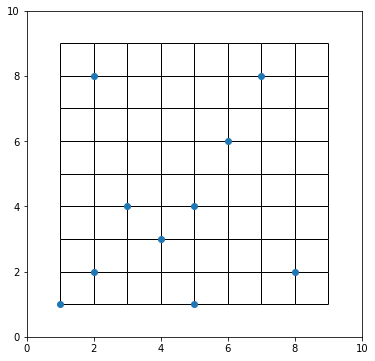

In [17]:
plot_graph(G)

In [18]:
G = remove_edges_landscape_method(G, Nx0=40, alpha=0.8)

number of original edges 144
number of final edges 52


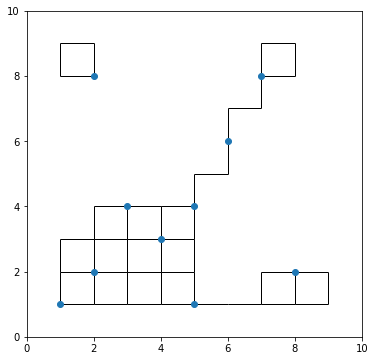

In [19]:
plot_graph(G)

# Example 2
Points selected at random. Try varying alpha for different results. Higher alpha includes more edges

In [20]:
points2 = np.random.randint(18, size=(40, 2)) + 1

In [21]:
G_ex2 = create_graph(L = 20, points=convert_points_array_to_list(points2))

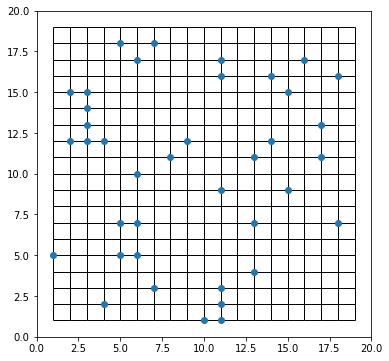

In [22]:
plot_graph(G_ex2)

In [23]:
G_ex2_preprocessed = remove_edges_landscape_method(G_ex2, Nx0=40, alpha=0.8)

number of original edges 684
number of final edges 77


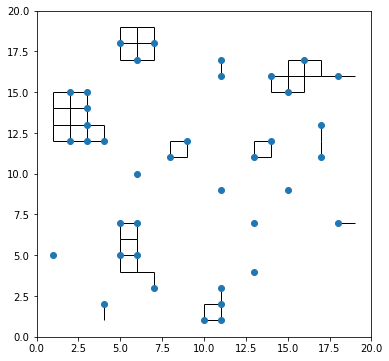

In [24]:
plot_graph(G_ex2_preprocessed)

# Steiner tree

## Example 1

In [25]:
points = [(1, 1), (2, 2), (3, 4), (5, 1), (5, 4), (8, 2), (7, 8), (6,  6), (2,8), (4,3)]

In [26]:
G = create_graph(L=10, points=points)

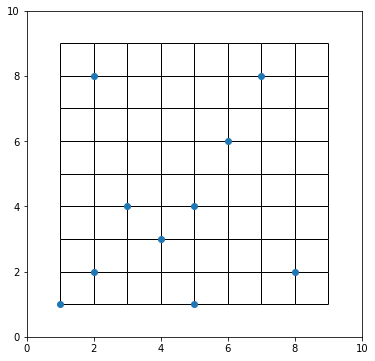

In [27]:
plot_graph(G)

In [28]:
G_st = get_naive_steiner(G)

The number of edges of the Steiner tree is 26


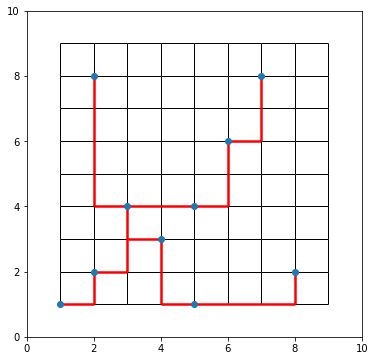

In [29]:
plot_graph(G, tree=G_st)

In [30]:
G_ld = remove_edges_landscape_method(G, Nx0=40, alpha=0.5)

number of original edges 144
number of final edges 23


In [31]:
G_ld_st = get_steiner_per_component(G_ld)

The total number of edges of the Steiner trees is 8


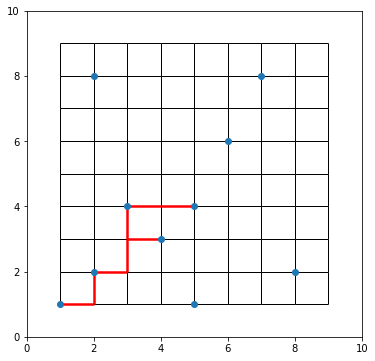

In [32]:
plot_graph(G, tree=G_ld_st)

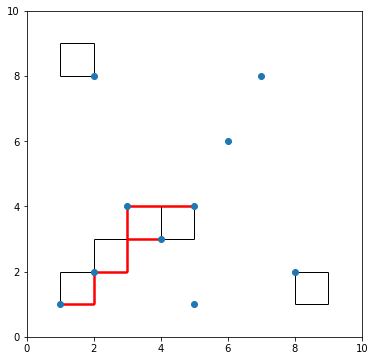

In [33]:
plot_graph(G_ld, tree=G_ld_st)

## Example 2

In [34]:
L = 40
points2 = [(np.random.randint(L-2) + 1, np.random.randint(L-2) + 1) for i in range(250) ]

In [35]:
G = create_graph(L, points=convert_points_array_to_list(points2)).to_undirected()

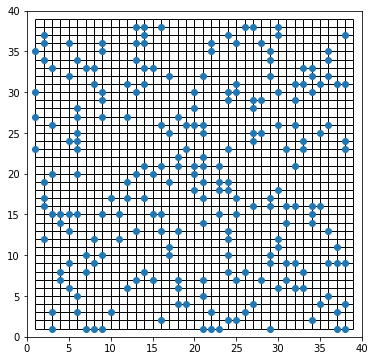

In [36]:
plot_graph(G)

In [37]:
G_st = get_naive_steiner(G)

The number of edges of the Steiner tree is 439


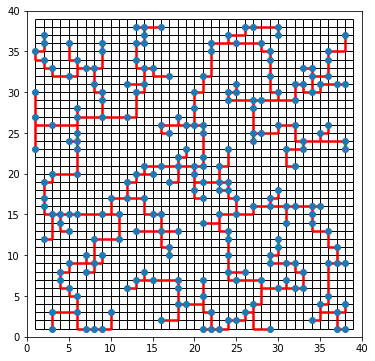

In [38]:
plot_graph(G, tree=G_st)

In [39]:
G_ld = remove_edges_landscape_method(G, Nx0=40, alpha=1.5)

number of original edges 2964
number of final edges 1089


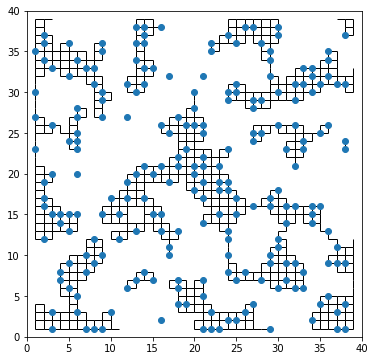

In [40]:
plot_graph(G_ld)

In [41]:
G_ld_st = get_steiner_per_component(G_ld)

The total number of edges of the Steiner trees is 400


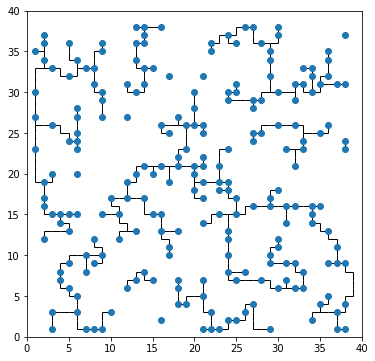

In [42]:
plot_graph(G_ld_st)

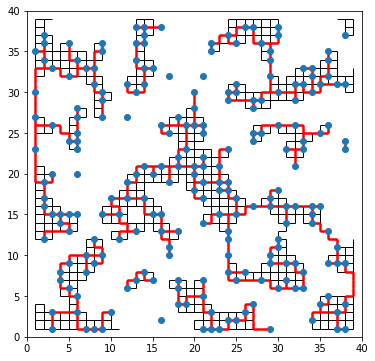

In [43]:
plot_graph(G_ld, tree=G_ld_st)